# Building Transformer

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from transformers.tokenization_utils_base import BatchEncoding

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List

## Tokenizer

### Types of Tokenizers

#### BPE

In [2]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [3]:
word = "المدرسة"

In [6]:
len(tokenizer(word)["input_ids"])

9

In [88]:
model_name = "aubmindlab/bert-large-arabertv2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

model.safetensors:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

In [91]:
model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}

In [8]:
len(tokenizer(word)["input_ids"])

5

#### Unigram

In [9]:
model_name = "google/mt5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [10]:
len(tokenizer(word)["input_ids"])

4

### Load Dataset

In [11]:
# dataset = load_dataset("oscar", "unshuffled_deduplicated_ar") # Large & requires permission
dataset = load_dataset("arbml/ArSAS")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [23]:
df = pd.DataFrame(dataset["train"])
df["tokens_len"] = df["Tweet_text"].apply(lambda x: len(x.split()))

In [ ]:
df["tokens_len"].quantile(0.9)

np.float64(37.0)

<Axes: ylabel='Density'>

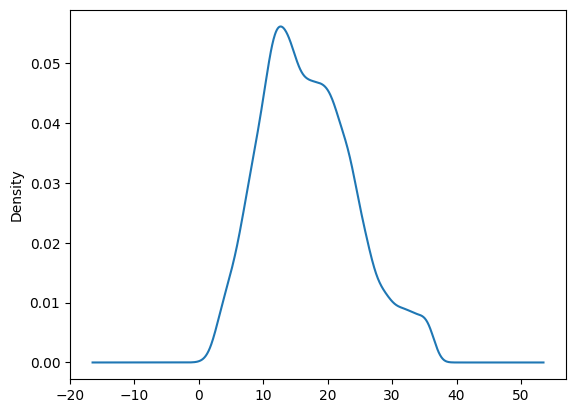

In [27]:
df[df["tokens_len"] < df["tokens_len"].quantile(0.9)]["tokens_len"].plot(kind="density")

In [17]:
text_corpus: List[str] = pd.DataFrame(dataset["train"])["Tweet_text"].tolist()

In [18]:
len(text_corpus)

19897

In [32]:
text_tokens["input_ids"]

[[33,
  7214,
  1226,
  21890,
  32,
  38,
  9067,
  120,
  38,
  613,
  27099,
  27259,
  5665,
  3901,
  251,
  290,
  7214,
  41184,
  251,
  32,
  54,
  3348,
  440,
  7248,
  6958,
  1525,
  6358,
  32,
  2744,
  613,
  59,
  22481,
  6291,
  1793,
  304,
  1228,
  1300,
  251,
  42,
  408,
  4079,
  1152,
  26270,
  162,
  53541,
  14156,
  196,
  43,
  32,
  8151,
  37305,
  54,
  59,
  1560,
  157,
  1852,
  251,
  59,
  407,
  32,
  50,
  32,
  32,
  56308,
  37396,
  1998,
  48,
  132,
  32,
  104,
  50287,
  30267,
  59,
  32,
  32,
  116,
  48,
  42638,
  32,
  10846,
  285,
  32528,
  281,
  238,
  279,
  283,
  248,
  34],
 [33,
  1081,
  405,
  443,
  1125,
  251,
  977,
  223,
  9351,
  46632,
  9951,
  686,
  2331,
  6689,
  47776,
  303,
  59,
  38,
  32110,
  219,
  3722,
  5460,
  1729,
  162,
  52,
  24149,
  38,
  27825,
  3655,
  5397,
  6947,
  839,
  2331,
  7214,
  2815,
  199,
  7214,
  31156,
  16158,
  47220,
  251,
  6689,
  351,
  16398,
  38,
  1294,
  3

In [34]:
# Tokenization ...
text_tokens = tokenizer(text_corpus, truncation=True)

#### Plotting the Distribution

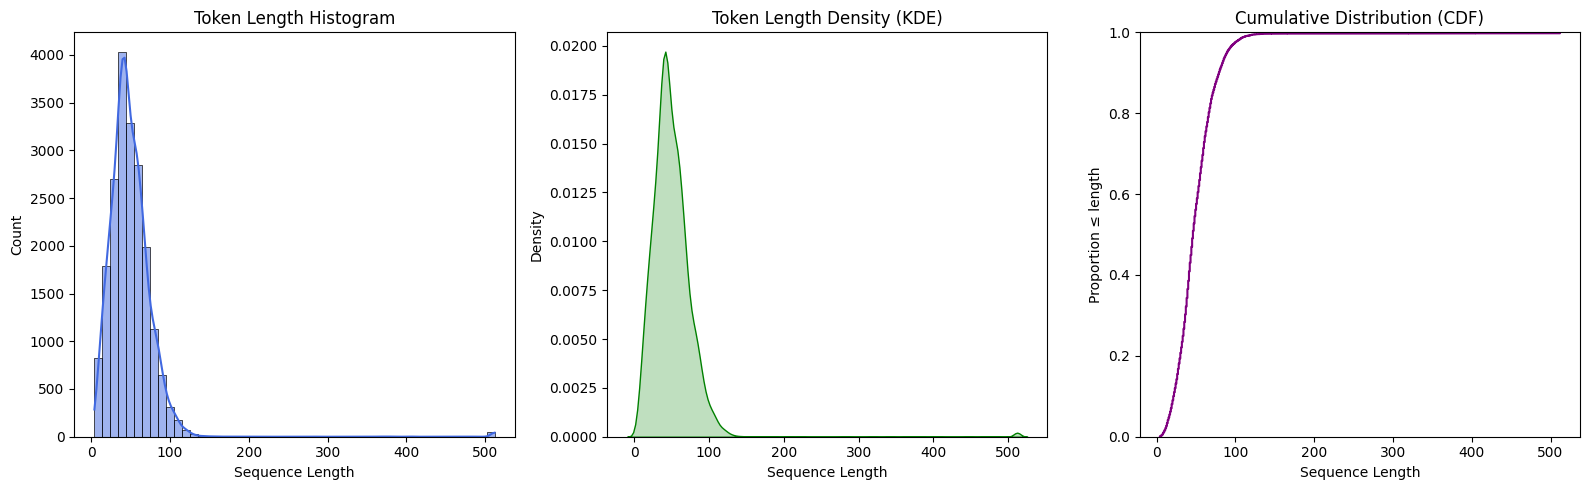

In [35]:
# Compute true sequence lengths (ignoring padding)
lengths = [len(t) for t in text_tokens["input_ids"]]

plt.figure(figsize=(16, 5))

# --- Histogram ---
plt.subplot(1, 3, 1)
sns.histplot(lengths, bins=50, kde=True, color="royalblue")
plt.title("Token Length Histogram")
plt.xlabel("Sequence Length")
plt.ylabel("Count")

# --- KDE Density ---
plt.subplot(1, 3, 2)
sns.kdeplot(lengths, fill=True, color="green")
plt.title("Token Length Density (KDE)")
plt.xlabel("Sequence Length")
plt.ylabel("Density")

# --- CDF Plot ---
plt.subplot(1, 3, 3)
sns.ecdfplot(lengths, color="purple")
plt.title("Cumulative Distribution (CDF)")
plt.xlabel("Sequence Length")
plt.ylabel("Proportion ≤ length")

plt.tight_layout()
plt.show()


### Config

In [97]:
class config:
    batch_size = 10
    hidden_size = 768
    n_heads = ...
    max_seq_len = 128
    vocab_size = tokenizer.vocab_size
    base = ...
    pad_id = 0
    cls_token = 33
    sep_token = 34
    ignored_index = -100

## Dataset & DataLoader

In [42]:
ids = torch.tensor(text_tokens["input_ids"][0])
ids

tensor([   33,  7214,  1226, 21890,    32,    38,  9067,   120,    38,   613,
        27099, 27259,  5665,  3901,   251,   290,  7214, 41184,   251,    32,
           54,  3348,   440,  7248,  6958,  1525,  6358,    32,  2744,   613,
           59, 22481,  6291,  1793,   304,  1228,  1300,   251,    42,   408,
         4079,  1152, 26270,   162, 53541, 14156,   196,    43,    32,  8151,
        37305,    54,    59,  1560,   157,  1852,   251,    59,   407,    32,
           50,    32,    32, 56308, 37396,  1998,    48,   132,    32,   104,
        50287, 30267,    59,    32,    32,   116,    48, 42638,    32, 10846,
          285, 32528,   281,   238,   279,   283,   248,    34])

In [44]:
x = ids[:-1]
y = ids[1:]
y

tensor([ 7214,  1226, 21890,    32,    38,  9067,   120,    38,   613, 27099,
        27259,  5665,  3901,   251,   290,  7214, 41184,   251,    32,    54,
         3348,   440,  7248,  6958,  1525,  6358,    32,  2744,   613,    59,
        22481,  6291,  1793,   304,  1228,  1300,   251,    42,   408,  4079,
         1152, 26270,   162, 53541, 14156,   196,    43,    32,  8151, 37305,
           54,    59,  1560,   157,  1852,   251,    59,   407,    32,    50,
           32,    32, 56308, 37396,  1998,    48,   132,    32,   104, 50287,
        30267,    59,    32,    32,   116,    48, 42638,    32, 10846,   285,
        32528,   281,   238,   279,   283,   248,    34])

In [47]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [53]:
class NanoDataset(Dataset):

    def __init__(self, corpus: BatchEncoding):
        self.corpus_tokens = corpus["input_ids"]

    def __len__(self):
        return len(self.corpus_tokens)

    def __getitem__(self, idx):

        ids = torch.tensor(self.corpus_tokens[idx])
        
        if len(ids) < 2:
            ids = [config.cls_token, config.sep_token]

        x = ids[:-1]
        y = ids[1:]
        return {"input_ids": x, "labels": y}

In [54]:
ds = NanoDataset(text_tokens)

In [68]:
batch_s = [ds[i]["input_ids"] for i in range(100)]

In [69]:
batch_s_p = pad_sequence(batch_s, batch_first=True)

In [78]:
(batch_s_p != 0).long()

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [79]:
def collate_fn(batch: List[Dict[str, torch.Tensor]]):
    """Takes list of items of the dataset

        i.e:
    >>> ds = NanoDataset(tokenized_corpus)
    >>> [ds[i] for i in ds]
    """
    input_ids = [b["input_ids"] for b in batch]
    labels = [b["labels"] for b in batch]

    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=config.pad_id)
    labels = pad_sequence(labels, batch_first=True, padding_value=config.ignored_index)

    return {
        "input_ids": input_ids,
        "labels": labels,
        "attention_mask": (input_ids != config.pad_id).long(),
    }

In [80]:
ds = NanoDataset(text_tokens)

In [83]:
train_dataloader = DataLoader(
    dataset=ds,
    batch_size=config.batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    )

In [86]:
for batch in train_dataloader:
    print(batch)
    break

{'input_ids': tensor([[   33,   613,  5764,  ...,     0,     0,     0],
        [   33,    38, 15624,  ...,     0,     0,     0],
        [   33,    38,  7248,  ...,     0,     0,     0],
        ...,
        [   33,  1081,  8771,  ...,     0,     0,     0],
        [   33,  1350,   251,  ...,     0,     0,     0],
        [   33, 40722,   210,  ...,     0,     0,     0]]), 'labels': tensor([[  613,  5764, 15889,  ...,  -100,  -100,  -100],
        [   38, 15624,   124,  ...,  -100,  -100,  -100],
        [   38,  7248,    95,  ...,  -100,  -100,  -100],
        ...,
        [ 1081,  8771,    38,  ...,  -100,  -100,  -100],
        [ 1350,   251,   613,  ...,  -100,  -100,  -100],
        [40722,   210, 35058,  ...,  -100,  -100,  -100]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [87]:
tokenizer.vocab_size

64000

In [95]:
batch["input_ids"].shape

torch.Size([10, 114])

In [96]:
emb(batch["input_ids"]).shape

torch.Size([10, 114, 768])

### Demo Model

In [98]:
class SModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Embedding(config.vocab_size, config.hidden_size),
            nn.Linear(config.hidden_size, 1024),
            nn.Linear(1024, config.vocab_size),
        )

    def forward(self, x):
        # x: B T D
        return self.net(x)

In [99]:
model = SModel()

In [100]:
logits = model(batch["input_ids"])

In [102]:
logits.shape

torch.Size([10, 114, 64000])

In [108]:
logits.view(-1, config.vocab_size).shape

torch.Size([1140, 64000])

In [103]:
criterion = nn.CrossEntropyLoss()

In [106]:
labels = batch["labels"]
labels.shape

torch.Size([10, 114])

In [109]:
labels.view(-1).shape

torch.Size([1140])

In [110]:
criterion(logits.view(-1, config.vocab_size), labels.view(-1))

tensor(11.1279, grad_fn=<NllLossBackward0>)

## Modelling

### Attention Module

### MLP Module

### Block

### GPT